In [1]:
'''数学基础: softmax, 交叉熵, 损失函数'''

'数学基础: softmax, 交叉熵, 损失函数'

In [2]:
# softmax 与 交叉熵
# problem: 将回归模型转为多分类模型
# 回归：估计一个连续值
# 分类：预测一个离散类别
# 【假设】
# 共有n种类别，每个样本只对应一个分类(one-hot), 真实分类为第z个分类
# 真实分布为y，预测分布为y_hat
# y为只有唯一元素为1，其余为0的n维向量；而y_hat为元素之和为1的n维向量
# 只考虑一个样本X
# 通过回归模型计算对属于第i个分类的预测值为O[i]

# 【softmax函数】
# for j in range(n): sum += e**(O[j])
# 则, softmax函数 y_hat[i] = S[i] = e**O[i] / sum

# 【交叉熵】
# 相对熵(KL散度): 独立变量X的两个概率分布P,Q, D_KL(P||Q)表示“用P表示X代替用Q表示X得到的信息增量“
# D_KL(P||Q) = sum( P(X_i)*log(P(X_i)/Q(X_i)) )
# 当P代表真实分布，Q代表预测分布时，D_KL(P||Q)表示“从预测分布到真实分布需要的信息增量”
# 此时D_KL(P||Q)可以化简为H(p,q) = -sum( P(X_i)*log(Q(X_i)) ) = -sum( y[i]*log(y_hat[i]) )
# 则, 交叉熵 loss = -sum( y[i]*log(y_hat[i]) ) = -log(y_hat[z])
# 【交叉熵loss的梯度】
# grad(loss, O[i]) = grad(-log(y_hat[z]), O[i]) = grad(-log(e**O[z]/sum), O[i])
#                  = grad(-log(e**O[z])+log(sum), O[i]) = grad(-O[z]+log(sum), O[i]) 
# 当z!=i时,y[i]=0, grad(-O[z]+log(sum),O[i]) = grad(log(sum),O[i])-0 = grad(log(sum),O[i])-y[i]
# 当z==i时,y[i]=1, grad(-O[z]+log(sum),O[i]) = grad(log(sum),O[i])-1 = grad(log(sum),O[i])-y[i]
# 则, grad(loss, O[i]) = grad(log(sum),O[i])-y[i] = 1/sum*grad(sum, O[i])-y[i] =  1/sum*(e**O[i])-y[i] 
#                      = y_hat[i]-y[i] 
# 即，loss的梯度是softmax函数值与真实值的差

# 【softmax函数和交叉熵loss的关系】
# loss的梯度是softmax函数值与真实值的差
# 所以，采用梯度下降法时不断减去loss的梯度，即不断减去softmax函数值与真实值的差，使得softmax函数值与真实值越来越接近

# # 展示对应笔记：./notes/09_SoftmaxAndCrossEntropy.JPG
# from PIL import Image
# img=Image.open("./notes/09_SoftmaxAndCrossEntropy.JPG")
# img.show()

In [3]:
# 损失函数 loss(y,y_hat) 
# 衡量预测值和真实值间的区别
# L1 Loss (绝对值损失)
# 梯度的绝对值相同，在0点处不可导
# l1_loss(y,y_hat) = abs(y-y_hat)
# L2 Loss (均方损失)
# 当预测值和真实值间的区别大时，梯度绝对值很大，快速地下降
# 当预测值接近真实值时，梯度绝对值较小，缓慢地下降
# l2_loss(y,y_hat) = 1/2 * (y-y_hat)**2
# Huber's Robust Loss (结合L1和L2，优化较平滑)
# 当预测值和真实值间的区别大时，梯度绝对值相同，均匀地下降
# 当预测值接近真实值时(abs(y-y_hat)<=1)，越接近真实值时梯度绝对值越减小，缓慢地下降
# huber_loss(y,y_hat) = abs(y-y_hat) if abs(y-y_hat)>1 else 1/2 * (y-y_hat)**2 

In [4]:
'''使用Fashion-MNIST数据集'''

'使用Fashion-MNIST数据集'

In [5]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display() #用svg显示图片，图片清晰度更高

In [6]:
# 使用Fashion-MNIST数据集
# Fashion-MNIST由10个类别的图像组成，每个类别由训练数据集中的6000张图像和测试数据集中的1000张图像组成。
# 即，训练集和测试集分别包含60000和10000张图像

# 通过框架内置函数将Fashion-MNIST数据集下载并读取到内存中
# root:存储路径; train:下载训练数据集; transform:转为tensor格式(从PLT类型转为32位浮点数类型且除以255使得所有像素数值在0到1之间); download:从网上下载
mnist_train = torchvision.datasets.FashionMNIST(
    root="./datas", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./datas", train=False, transform=transforms.ToTensor(), download=True)

# 测试
print(len(mnist_train),len(mnist_test)) #输出样本总数量
# 第i张测试样本图片的所有像素为mnist_train[i][0], 对应的标签为mnist_train[i][1]
print(mnist_train[0][0].shape) #输出第1张图片的形状
print(mnist_train[0][1]) #输出第1张图片的标签

60000 10000
torch.Size([1, 28, 28])
9


In [7]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return[text_labels[int(i)] for i in labels]

# 测试
print(get_fashion_mnist_labels([1, 3]))#输出[1, 3]对应的标签

['trouser', 'dress']


array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>], dtype=object)

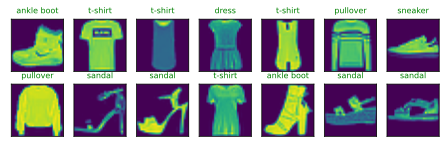

In [8]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.1):
    """可视化样本数据"""
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    # zip函数: a=[1,2,3]; c=[4,5,6,7,8]; *zip(a,c)=(1,4) (2,5) (3,6)
    # enumerate函数: seq=['a','b','c']; enumerate(seq)=[(0,'a'),(1,'b'),(2,'c')]
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img): #img是图片张量
            ax.imshow(img.numpy())
        else: #img是PIL
            ax.imshow(img)
        #不显示横纵坐标轴
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i], color='g', fontsize=8)
    return axes

# 测试
# 取14张样本进行可视化(行数为2,列数为7)
X, y = next(iter(data.DataLoader(mnist_train, batch_size=14)))
show_images(X.reshape(14,28,28), 2, 7, titles=get_fashion_mnist_labels(y))

In [9]:
def get_dataloader_workers():
    """使用4个进程读取数据"""
    return 4

# 测试读取时间
# 读取时间要比训练时间快
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X,y in train_iter:
    continue
spendTime = timer.stop()
print(f'Spend time: {spendTime:.2f} seconds')

Spend time: 2.42 seconds


In [10]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集并读取到内存中"""
    trans = [transforms.ToTensor()]
    if resize: #是否将图像大小调整为另一种形状
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans) #transforms.Compose串联多个transform操作
    
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./datas", train=True, transform=trans, download=True)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./datas", train=True, transform=trans, download=True)
    
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

# 测试
batch_size = 32
train_iter, test_iter = load_data_fashion_mnist (batch_size, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [11]:
'''从零开始实现softmax回归'''

'从零开始实现softmax回归'

In [ ]:
import torch
from IPython import display
for d2l import torch as d2l

# 读取Fashion-MNIST数据集
batch_size=256
train_iter, test_iter=d2l.load_data_fashion_mnist(batch_size)

In [ ]:
num_inputs = int(28*28) #输入特征为每张图片的28*28个像素点
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs,num_outputs), requires_grad=True) 
b = torch.zeros(num_outputs, requires_grad=True)

In [19]:
def softmax(X):
    """实现softmax函数"""
    X_exp = torch.exp(X) #对输出值求幂
    partition = X_exp.sum(1, keepdim=True) #按行求和, 对每一个样本的所有输出幂值求和(对应上述数学基础的sum)
    return X_exp / partition #应用了广播机制

# 测试
X = torch.normal(0, 1, (2,5))
X_prob = softmax(X)
print('X:', X)
print('softmax(X):', softmax(X))
print('softmax(X).sum(1):', softmax(X).sum(1))

X: tensor([[ 1.0903,  2.2029,  0.3573, -2.0421, -0.1330],
        [-0.5956,  0.2070, -1.7908, -0.8450,  1.7440]])
softmax(X): tensor([[0.2057, 0.6259, 0.0988, 0.0090, 0.0605],
        [0.0681, 0.1519, 0.0206, 0.0530, 0.7064]])
softmax(X).sum(1): tensor([1., 1.])
